In [1]:
#Real Code
import numpy as np
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from tqdm import tqdm_notebook 

from sklearn.preprocessing import OneHotEncoder

In [2]:
(x_train,y_train),(x_val,y_val)=fashion_mnist.load_data()
x_train = x_train.astype('float')/ 255.0
x_val = x_val.astype('float')/ 255.0
print(x_train.shape, x_val.shape,y_train.shape,y_val.shape,type(x_train[0][0]),x_train[0][0])
x_train = x_train.reshape(60000,784)
x_val = x_val.reshape(10000,784)
print(x_train.shape, x_val.shape,y_train.shape,y_val.shape,type(x_train[0][0]),x_train[0][0])

4431872/4422102 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28) (60000,) (10000,) <class 'numpy.ndarray'> [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
(60000, 784) (10000, 784) (60000,) (10000,) <class 'numpy.float64'> 0.0


## 10 percent for testing 

In [3]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.1,stratify=y_train, random_state=0)
print(x_train.shape, x_test.shape,y_train.shape,y_test.shape,type(x_train[0][0]),x_train[0][0])

(54000, 784) (6000, 784) (54000,) (6000,) <class 'numpy.float64'> 0.0


In [4]:
enc = OneHotEncoder()
# 0 -> (1, 0, 0, 0), 1 -> (0, 1, 0, 0), 2 -> (0, 0, 1, 0), 3 -> (0, 0, 0, 1)
y_train1 = enc.fit_transform(np.expand_dims(y_train,1)).toarray()
y_test1 = enc.fit_transform(np.expand_dims(y_test,1)).toarray()
print(y_train1.shape, y_test1.shape)

(54000, 10) (6000, 10)


In [5]:
print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)

(54000, 784) (6000, 784) (54000,) (6000,)


In [6]:
class FFSN_MultiClass:
  
  def __init__(self, n_inputs, n_outputs, hidden_sizes=[3]):
    self.nx = n_inputs
    self.ny = n_outputs
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny] 

    self.W = {}
    self.B = {}
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1, self.sizes[i+1]))
      
  def sigmoid(self, x):
    return 1.0/(1.0 + np.exp(-x))
  
  def softmax(self, x):
    exps = np.exp(x)
    return exps / np.sum(exps)

  def forward_pass(self, x):
    self.A = {}
    self.H = {}
    self.H[0] = x.reshape(1, -1)
    for i in range(self.nh):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])
    self.A[self.nh+1] = np.matmul(self.H[self.nh], self.W[self.nh+1]) + self.B[self.nh+1]
    self.H[self.nh+1] = self.softmax(self.A[self.nh+1])
    return self.H[self.nh+1]
  
  def predict(self, X):
    Y_pred = []
    for x in X:
      y_pred = self.forward_pass(x)
      Y_pred.append(y_pred)
    return np.array(Y_pred).squeeze()
 
  def grad_sigmoid(self, x):
    return x*(1-x) 
  
  def cross_entropy(self,label,pred):
    yl=np.multiply(pred,label)
    yl=yl[yl!=0]
    yl=-np.log(yl)
    yl=np.mean(yl)
    return yl
 
  def grad(self, x, y):
    self.forward_pass(x)
    self.dW = {}
    self.dB = {}
    self.dH = {}
    self.dA = {}
    L = self.nh + 1
    self.dA[L] = (self.H[L] - y)
    for k in range(L, 0, -1):
      self.dW[k] = np.matmul(self.H[k-1].T, self.dA[k])
      self.dB[k] = self.dA[k]
      self.dH[k-1] = np.matmul(self.dA[k], self.W[k].T)
      self.dA[k-1] = np.multiply(self.dH[k-1], self.grad_sigmoid(self.H[k-1])) 
    
  def fit(self, X, Y, epochs=100, initialize='True', learning_rate=0.01, display_loss=False):
      
    if display_loss:
      loss = {}
      
    if initialize:
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1, self.sizes[i+1]))
        
    for epoch in tqdm_notebook(range(epochs), total=epochs, unit="epoch"):
      dW = {}
      dB = {}
      for i in range(self.nh+1):
        dW[i+1] = np.zeros((self.sizes[i], self.sizes[i+1]))
        dB[i+1] = np.zeros((1, self.sizes[i+1]))
      for x, y in zip(X, Y):
        self.grad(x, y)
        for i in range(self.nh+1):
          dW[i+1] += self.dW[i+1]
          dB[i+1] += self.dB[i+1]
                  
      m = X.shape[1]
      for i in range(self.nh+1):
        self.W[i+1] -= learning_rate * (dW[i+1]/m)
        self.B[i+1] -= learning_rate * (dB[i+1]/m)
        
      if display_loss:
        Y_pred = self.predict(X) 
        loss[epoch] = self.cross_entropy(Y, Y_pred)
    
    if display_loss:
      plt.plot(np.array(list(loss.values())).astype(float))
      plt.xlabel('Epochs')
      plt.ylabel('CE')
      plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/100 [00:00<?, ?epoch/s]

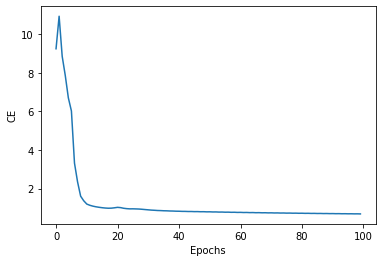

In [13]:
ffsn_multi = FFSN_MultiClass(784,10,[32]) #in the 3rd parameter we can add how many layers we want and size of each layer 
ffsn_multi.fit(x_train,y_train1,epochs=100,learning_rate=.1,display_loss=True)

In [14]:
Y_pred_train = ffsn_multi.predict(x_train)
Y_pred_train = np.argmax(Y_pred_train,1)

Y_pred_val = ffsn_multi.predict(x_test)
Y_pred_val = np.argmax(Y_pred_val,1)


accuracy_train = accuracy_score(Y_pred_train, y_train)
accuracy_val = accuracy_score(Y_pred_val, y_test)

print("Training accuracy", round(accuracy_train, 2))
print("Validation accuracy", round(accuracy_val, 2))

Training accuracy 0.75
Validation accuracy 0.74


In [15]:
print(ffsn_multi.forward_pass(x_train[0])) #if we pass a new element (image) we will get probability distribution over the 10 classes. 
print(y_train[0])

[[9.93393952e-03 2.84244855e-03 1.83474827e-01 1.34406842e-02
  5.67589236e-01 3.91198562e-04 1.98198569e-01 7.08591842e-04
  2.33328417e-02 8.76643179e-05]]
6
